In [14]:
import sys
sys.path.append('../')
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torchcde
pd.options.mode.chained_assignment = None

In [2]:
torch.set_printoptions(precision=5, sci_mode=False)
np.set_printoptions(suppress=True)

In [3]:
data_1 = pd.read_csv("EURODOLLAR19.csv", encoding = "UTF-16 LE",  parse_dates=['DateTime'])
data_2 = pd.read_csv("EURODOLLAR20.csv", encoding = "UTF-16 LE",  parse_dates=['DateTime'])
data = pd.concat([data_1, data_2], axis=0)

In [4]:
data =data.reset_index()

In [5]:
data.shape

(2527762, 4)

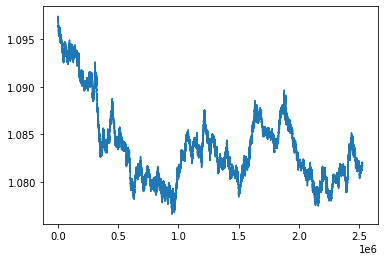

In [6]:
plt.plot(data['Bid'])

In [7]:
data = data.drop(['Bid', 'index'], axis=1)

In [8]:
data_ = data.groupby(pd.Grouper(key='DateTime', freq='30s')).mean()

In [9]:
data_.shape

(34553, 1)

In [10]:
data_.head()

,Ask
DateTime,
2020-05-03 21:03:00,1.097473
2020-05-03 21:03:30,1.097405
2020-05-03 21:04:00,NaN
2020-05-03 21:04:30,1.097420
2020-05-03 21:05:00,1.097552


In [11]:
data_['Ask'].isnull().sum()

6252

In [12]:
data_torch = torch.tensor(np.array(data_))

In [15]:
coeffs = torchcde.linear_interpolation_coeffs(data_torch)
X = torchcde.LinearInterpolation(coeffs)

In [16]:
X_eval = X.evaluate(torch.arange(0, data_torch.shape[0]))

In [17]:
data_.tail()

,Ask
DateTime,
2020-05-15 20:57:00,1.082123
2020-05-15 20:57:30,1.082096
2020-05-15 20:58:00,1.082172
2020-05-15 20:58:30,1.082178
2020-05-15 20:59:00,1.082260


In [18]:
X_eval[torch.isnan(X_eval)]

tensor([], dtype=torch.float64)

In [19]:
X_eval = X_eval.unsqueeze(0)
X_eval.shape

torch.Size([1, 34553, 1])

In [20]:
n_x, n_y = 80, 80
data_tensor = []
for i in range(0, X_eval.shape[1]-n_x-n_y):
    try:
        data_tensor.append(torch.tensor(X_eval[:, i:(i+n_x+n_y), :]))
    except:
        pass

data_tensor = torch.cat(data_tensor, dim=0)

C:\Users\pere9\AppData\Local\Temp\ipykernel_20576\1648589457.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensor.append(torch.tensor(X_eval[:, i:(i+n_x+n_y), :]))


In [21]:
data_tensor.shape

torch.Size([34393, 160, 1])

In [22]:
test = data_tensor[20000:30000]
data_tensor = data_tensor[:20000]

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
train, val = train_test_split(data_tensor, test_size=0.25, random_state=42)

In [25]:
train.shape, val.shape, test.shape

(torch.Size([15000, 160, 1]),
 torch.Size([5000, 160, 1]),
 torch.Size([10000, 160, 1]))

In [26]:
data = {}

In [27]:
data['X_train'], data['Y_train'] = train[:, :n_x, :1], train[:, (n_x-1):, :1]
data['X_val'], data['Y_val'] = val[:, :n_x, :1], val[:, (n_x-1):, :1]
data['X_test'], data['Y_test'] = test[:, :n_x, :1], test[:, (n_x-1):, :1]

In [28]:
data['X_train'] = torch.cat([torch.arange(0, data['X_train'].shape[1]).repeat(
    data['X_train'].shape[0], 1).unsqueeze(2), data['X_train']], dim=2)

data['Y_train'] = torch.cat([torch.arange(0, data['Y_train'].shape[1]).repeat(
    data['Y_train'].shape[0], 1).unsqueeze(2), data['Y_train']], dim=2)

data['X_val'] = torch.cat([torch.arange(0, data['X_val'].shape[1]).repeat(
    data['X_val'].shape[0], 1).unsqueeze(2), data['X_val']], dim=2)

data['Y_val'] = torch.cat([torch.arange(0, data['Y_val'].shape[1]).repeat(
    data['Y_val'].shape[0], 1).unsqueeze(2), data['Y_val']], dim=2)

data['X_test'] = torch.cat([torch.arange(0, data['X_test'].shape[1]).repeat(
    data['X_test'].shape[0], 1).unsqueeze(2), data['X_test']], dim=2)

data['Y_test'] = torch.cat([torch.arange(0, data['Y_test'].shape[1]).repeat(
    data['Y_test'].shape[0], 1).unsqueeze(2), data['Y_test']], dim=2)

In [29]:
data_or = {}

In [30]:
for dataset in data:
    data_or[dataset] = torch.clone(data[dataset])
    data[dataset][:, :, 1] = torch.log(data[dataset][:, :, 1]).float()

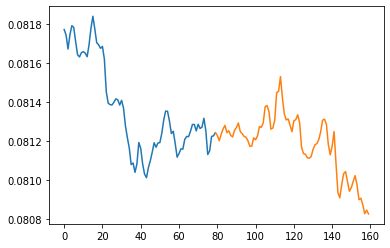

In [31]:
plt.plot(data['X_train'][0, :, 1])
plt.plot(data['X_train'][0, -1, 0]+data['Y_train'][0, :, 0], data['Y_train'][0, :, 1])

In [32]:
mean_logprice, std_logprice = data['X_train'][:, :, 1].mean(), data['X_train'][:, :, 1].std()

In [33]:
stats_data = {'mean': mean_logprice, 'std': std_logprice}
torch.save(stats_data, 'stats_data.pt')

In [34]:
for dataset in data:
    data[dataset][:, :, 1] = (data[dataset][:, :, 1]-mean_logprice)/std_logprice

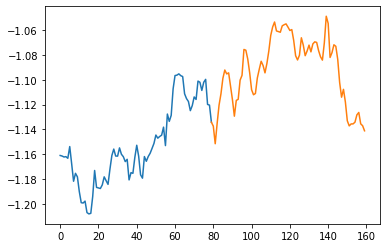

In [35]:
i=100
plt.plot(data['X_train'][i, :, 1])
plt.plot(data['X_train'][0, -1, 0]+data['Y_train'][0, :, 0], data['Y_train'][i, :, 1])

In [36]:
torch.save(data, 'data.pt')

### Some data analysis

In [37]:
x = data['X_train'][:, -1:, 1:]
y = data['Y_train'][:, 1:, 1:]

In [38]:
inc = torch.ones(y.shape)*x
inc_ = y-inc
inc_max = torch.max(inc_, dim=1)[0].squeeze(1)

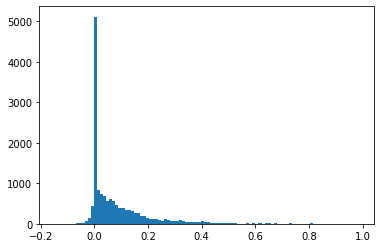

In [39]:
a = plt.hist(inc_max.numpy(), bins=100)

In [46]:
np.quantile(inc_max, 0.90)

0.2371344443494352

In [41]:
inc_min = torch.min(inc_, dim=1)[0].squeeze(1)

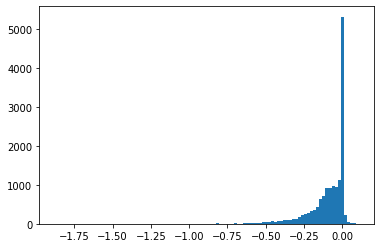

In [42]:
a = plt.hist(inc_min.numpy(), bins=100)

In [43]:
np.quantile(inc_min, 0.10)

-0.25124528959291265